In [2]:
#import pandas as pd
import fastf1
import matplotlib.pyplot as plt

fastf1.Cache.enable_cache("cachefolder")
#fastf1.events.get_events_remaining()
session = fastf1.get_testing_session(2023,1,2) #working session
#session = fastf1.get_session(2023,2,1)
fastf1.get_event_schedule(2023)
session.load()

core           INFO 	Loading data for Pre-Season Testing - Practice 2 [v2.3.0]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
c:\Users\Bartek\AppData\Local\Programs\Python\Python38-32\lib\site-packages\fastf1\core.py:1492: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for key, value in row.iteritems():
c:\Users\Bartek\AppData\Local\Programs\Python\Python38-32\lib\site-packages\fastf1\core.py:1492: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for key, value in row.iteritems():
c:\Users\Bartek\AppData\Local\Programs\Python\Python38-32\lib\site-packages\fastf1\core.py:1415: FutureWarning: I

In [3]:
lapsDataFrame = session.laps
raceControl = session.race_control_messages
drivers = session.drivers

In [4]:
#from datetime import datetime
def convert_timestamp_to_float(ts):
    return 60*int(ts.strftime('%H'))+int(ts.strftime('%M'))+int(ts.strftime('%S'))/60+float(ts.strftime('%f'))/60000000
def convert_adjusted_timestamp_to_float(adjts):
    return convert_timestamp_to_float(adjts)-(convert_timestamp_to_float(lapsDataFrame["LapStartDate"].to_list()[0])-convert_datetime_to_float(lapsDataFrame["LapStartTime"].to_list()[0]))


In [5]:
def getDriverLaps(driver_id):
    return lapsDataFrame[lapsDataFrame["DriverNumber"]==driver_id]

In [6]:
def getTeamList():
    teamlist = []
    for driver in drivers:
        if session.get_driver(driver).TeamName not in teamlist:
            teamlist.append(session.get_driver(driver).TeamName)
    return teamlist
def getDriverList(teamlist):
    driverlist = []
    for team in teamlist:
        for driver in drivers:
            if session.get_driver(driver).TeamName==team:
                driverlist.append(driver)
    return driverlist

In [7]:
cleanLapTimes = lapsDataFrame["LapTime"].to_list()
cleanLapTimes = [x for x in cleanLapTimes if str(x)!="NaT"]
sessionBest = min(cleanLapTimes)

In [8]:
def convert_datetime_to_float(dt):
    return (dt.seconds + dt.microseconds/1000000)/60
def convert_datetime_to_laptime(dt):
    if str(dt)!="NaT":
        if len(str(dt.seconds%60))==2:
            correctSeconds = str(dt.seconds%60)
        else:
            correctSeconds = "0"+str(dt.seconds%60)
        return str(dt.seconds//60)+":"+correctSeconds+"."+str(dt.microseconds)[0:3]
    else:
        return ""


In [9]:
def get_lap_dictionaries(lap_dataframe):
    laps = []

    pit_out_time = lap_dataframe["PitOutTime"].to_list()
    pit_in_time = lap_dataframe["PitInTime"].to_list()
    time = lap_dataframe["Time"].to_list()
    lap_start_time = lap_dataframe["LapStartTime"].to_list()

    lap_time = lap_dataframe["LapTime"].to_list()
    compound = lap_dataframe["Compound"].to_list()
    freshness = lap_dataframe["FreshTyre"].to_list()
    clean_lap_times = [x for x in lap_time if str(x)!="NaT"]
    try:
        personalBest = min(clean_lap_times)
    except:
        True
    for i in range(len(pit_out_time)):
        lap_dictionary = {}
        if str(pit_out_time[i]) != 'NaT':
            start_time = convert_datetime_to_float(pit_out_time[i])
        else:
            start_time = convert_datetime_to_float(lap_start_time[i])
        if str(pit_in_time[i]) != 'NaT':
            end_time = convert_datetime_to_float(pit_in_time[i])
        else:
            end_time = convert_datetime_to_float(time[i])
        lap_dictionary["start_time"] = start_time
        lap_dictionary["end_time"] = end_time
        lap_dictionary["lap_time"] = convert_datetime_to_laptime(lap_time[i])
        if lap_time[i]==sessionBest:
            lap_dictionary["tyre"] = "Session_Best"
        elif lap_time[i]==personalBest:
            lap_dictionary["tyre"] = "Personal_Best"
        else:    
            lap_dictionary["tyre"] = compound[i]+"_"+str(freshness[i])
        laps.append(lap_dictionary)

    return laps

In [10]:
compoundColors = {
    'SOFT_True': '#FF5F5F',
    'MEDIUM_True': '#F9E75E',
    'HARD_True': '#F0F0F0',
    'INTERMEDIATE_True': '#39B54A',
    'WET_True': '#00AEEF',
    'UNKNOWN_True': '#555555',
    'TEST_UNKNOWN_True': '#555555',


    'SOFT_False': '#933030',
    'MEDIUM_False': '#7c7600',
    'HARD_False': '#999999',
    'INTERMEDIATE_False': '#2b8737',
    'WET_False': '#0078a5',
    'UNKNOWN_False': '#222222',
    'TEST_UNKNOWN_False': '#222222',

    'Session_Best': '#b138dd',
    "Personal_Best": '#4dfbd7'
}

In [11]:
textColors = {
    'SOFT_True': '#000000',
    'MEDIUM_True': '#000000',
    'HARD_True': '#000000',
    'INTERMEDIATE_True': '#000000',
    'WET_True': '#000000',
    'UNKNOWN_True': '#FFFFFF',
    'TEST_UNKNOWN_True': '#FFFFFF',


    'SOFT_False': '#000000',
    'MEDIUM_False': '#000000',
    'HARD_False': '#000000',
    'INTERMEDIATE_False': '#000000',
    'WET_False': '#000000',
    'UNKNOWN_False': '#FFFFFF',
    'TEST_UNKNOWN_False': '#FFFFFF',

    'Session_Best': '#000000',
    'Personal_Best': '#000000'
}

In [24]:
rcmtimes = raceControl["Time"].to_list()
rcmmessages = raceControl["Message"].to_list()
rcmstatus = raceControl["Status"].to_list()
rcmcategory = raceControl["Category"].to_list()
rcmflags = raceControl["Flag"].to_list()
def getFirstGreenFlagTime():
    for i in range(len(rcmtimes)):
        if rcmflags[i]=="GREEN":
            return convert_adjusted_timestamp_to_float(rcmtimes[i])
def getSafetyCarPeriods():
    sc_begin = []
    sc_ending = []
    sc = False
    for i in range(len(rcmtimes)):
        if (not sc) and rcmcategory[i]=="SafetyCar" and rcmstatus[i]=="DEPLOYED":
            sc = True
            sc_begin.append(convert_adjusted_timestamp_to_float(rcmtimes[i]))
        if sc and (rcmmessages[i] =="RED FLAG" or rcmmessages[i]=="SESSION WILL NOT BE RESUMED" or rcmmessages[i]=="TRACK CLEAR" or rcmflags[i] =="CHEQUERED"):
            sc = False
            sc_ending.append(convert_adjusted_timestamp_to_float(rcmtimes[i]))
    if len(sc_begin) == len(sc_ending):
        return [sc_begin,sc_ending]
    else:
        print("[SAFETY CAR] UNEVEN BEGINNINGS AND ENDINGS")
        return [[],[]]
def getRedFlagPeriods():
    rf_begin = []
    rf_ending = []
    rf = False
    for i in range(len(rcmtimes)):
        if (not rf) and rcmcategory[i]=="Flag" and rcmflags[i]=="RED":
            rf = True
            rf_begin.append(convert_adjusted_timestamp_to_float(rcmtimes[i]))
        if rf and (rcmflags[i] =="GREEN" or rcmflags[i] =="CHEQUERED" or rcmmessages[i]=="SESSION WILL NOT BE RESUMED" or rcmmessages[i]=="AIR TEMPERATURE 1 HOUR BEFORE THE SESSION = 31.1 DEGREES"):
            rf = False
            rf_ending.append(convert_adjusted_timestamp_to_float(rcmtimes[i]))
    rf_ending.append(convert_adjusted_timestamp_to_float(rcmtimes[len(rcmtimes)-1]))
    print(rf_begin, rf_ending)
    if len(rf_begin) == len(rf_ending):
        return [rf_begin,rf_ending]
    else:
        print("[RED FLAG] UNEVEN BEGINNINGS AND ENDINGS")
        return [[],[]]
def getLastChequeredFlag():
    for i in range(len(rcmflags)):
        if rcmflags[i]=="CHEQUERED":
            fl = convert_adjusted_timestamp_to_float(rcmtimes[i])
    return fl

In [13]:
def create_testing_graphic(drivers, y_limit):
    plt.rcParams["figure.figsize"] = [30,20] #[40,20] for 10 teams [30,20] for less
    fig, ax = plt.subplots()
    ax.set_facecolor("#d9d9d9")
    fig.set_facecolor("#13151d")
    plt.ylim((y_limit[0]-y_limit[1],0))
    title = session.event["EventName"]+" 2022 "+session.name
    #plt.title(title.upper(), fontfamily="Bahnschrift", size = 40, color="white", pad=15)
    for i in range (len(drivers)):
        for lap in get_lap_dictionaries(getDriverLaps(drivers[i])):
            plt.bar(i, lap['end_time']-lap['start_time'],0.75, lap['start_time']-y_limit[1], color = compoundColors[lap['tyre']], edgecolor = "black")
            plt.text(i, lap['end_time']-y_limit[1]-(lap['end_time']-lap['start_time'])/2,lap['lap_time'],fontsize=15, verticalalignment='center',horizontalalignment='center',fontfamily='Arial', color=textColors[lap['tyre']])
    #adding red flags
    driverCounter = i
    redflagbegin = getRedFlagPeriods()[0]
    redflagend = getRedFlagPeriods()[1]
    for i in range(len(redflagbegin)):
        rect = plt.Rectangle((-0.5,redflagend[i]-y_limit[1]),driverCounter+1,redflagbegin[i]-redflagend[i],color = "r", alpha = 0.3)
        ax.add_patch(rect)
    scbegin = getSafetyCarPeriods()[0]
    scend = getSafetyCarPeriods()[1]
    for i in range(len(scbegin)):
        rect = plt.Rectangle((-0.5,scend[i]-y_limit[1]),driverCounter+1,scbegin[i]-scend[i],color = "y", alpha = 0.3)
        ax.add_patch(rect)
    tick = []
    for i in range(len(drivers)):
        tick.append(session.get_driver(drivers[i]).LastName.upper())
    ax.set_xticks([x for x in range(len(drivers))])
    ax.set_xticklabels(tick, fontfamily="Bahnschrift", size = 20, color="white")
    ax.tick_params(axis='x',pad=10)
    ax.tick_params(axis='y', colors='white', size = 10)
    plt.yticks(fontsize=15,fontfamily="Bahnschrift")
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    try:
        plt.axhline(y=getLastChequeredFlag()-y_limit[1], color = "black", linestyle = "--")
    except:
        1==1
    plt.savefig(title+" "+drivers[0],bbox_inches='tight',pad_inches=1)

In [ ]:
topdrivers = getDriverList(['Red Bull Racing', 'Ferrari', 'Mercedes', 'Alpine', 'McLaren'])
botdrivers = getDriverList(['Alfa Romeo', 'Aston Martin', 'Haas F1 Team', 'AlphaTauri', 'Williams'])

[252.08091666666667, 262.44758333333334, 482.33091666666667, 567.2642500000001, 576.7642500000001] [256.13091666666674, 264.06425, 502.91425000000004, 570.0142500000001, 578.8975833333334]
[252.08091666666667, 262.44758333333334, 482.33091666666667, 567.2642500000001, 576.7642500000001] [256.13091666666674, 264.06425, 502.91425000000004, 570.0142500000001, 578.8975833333334]


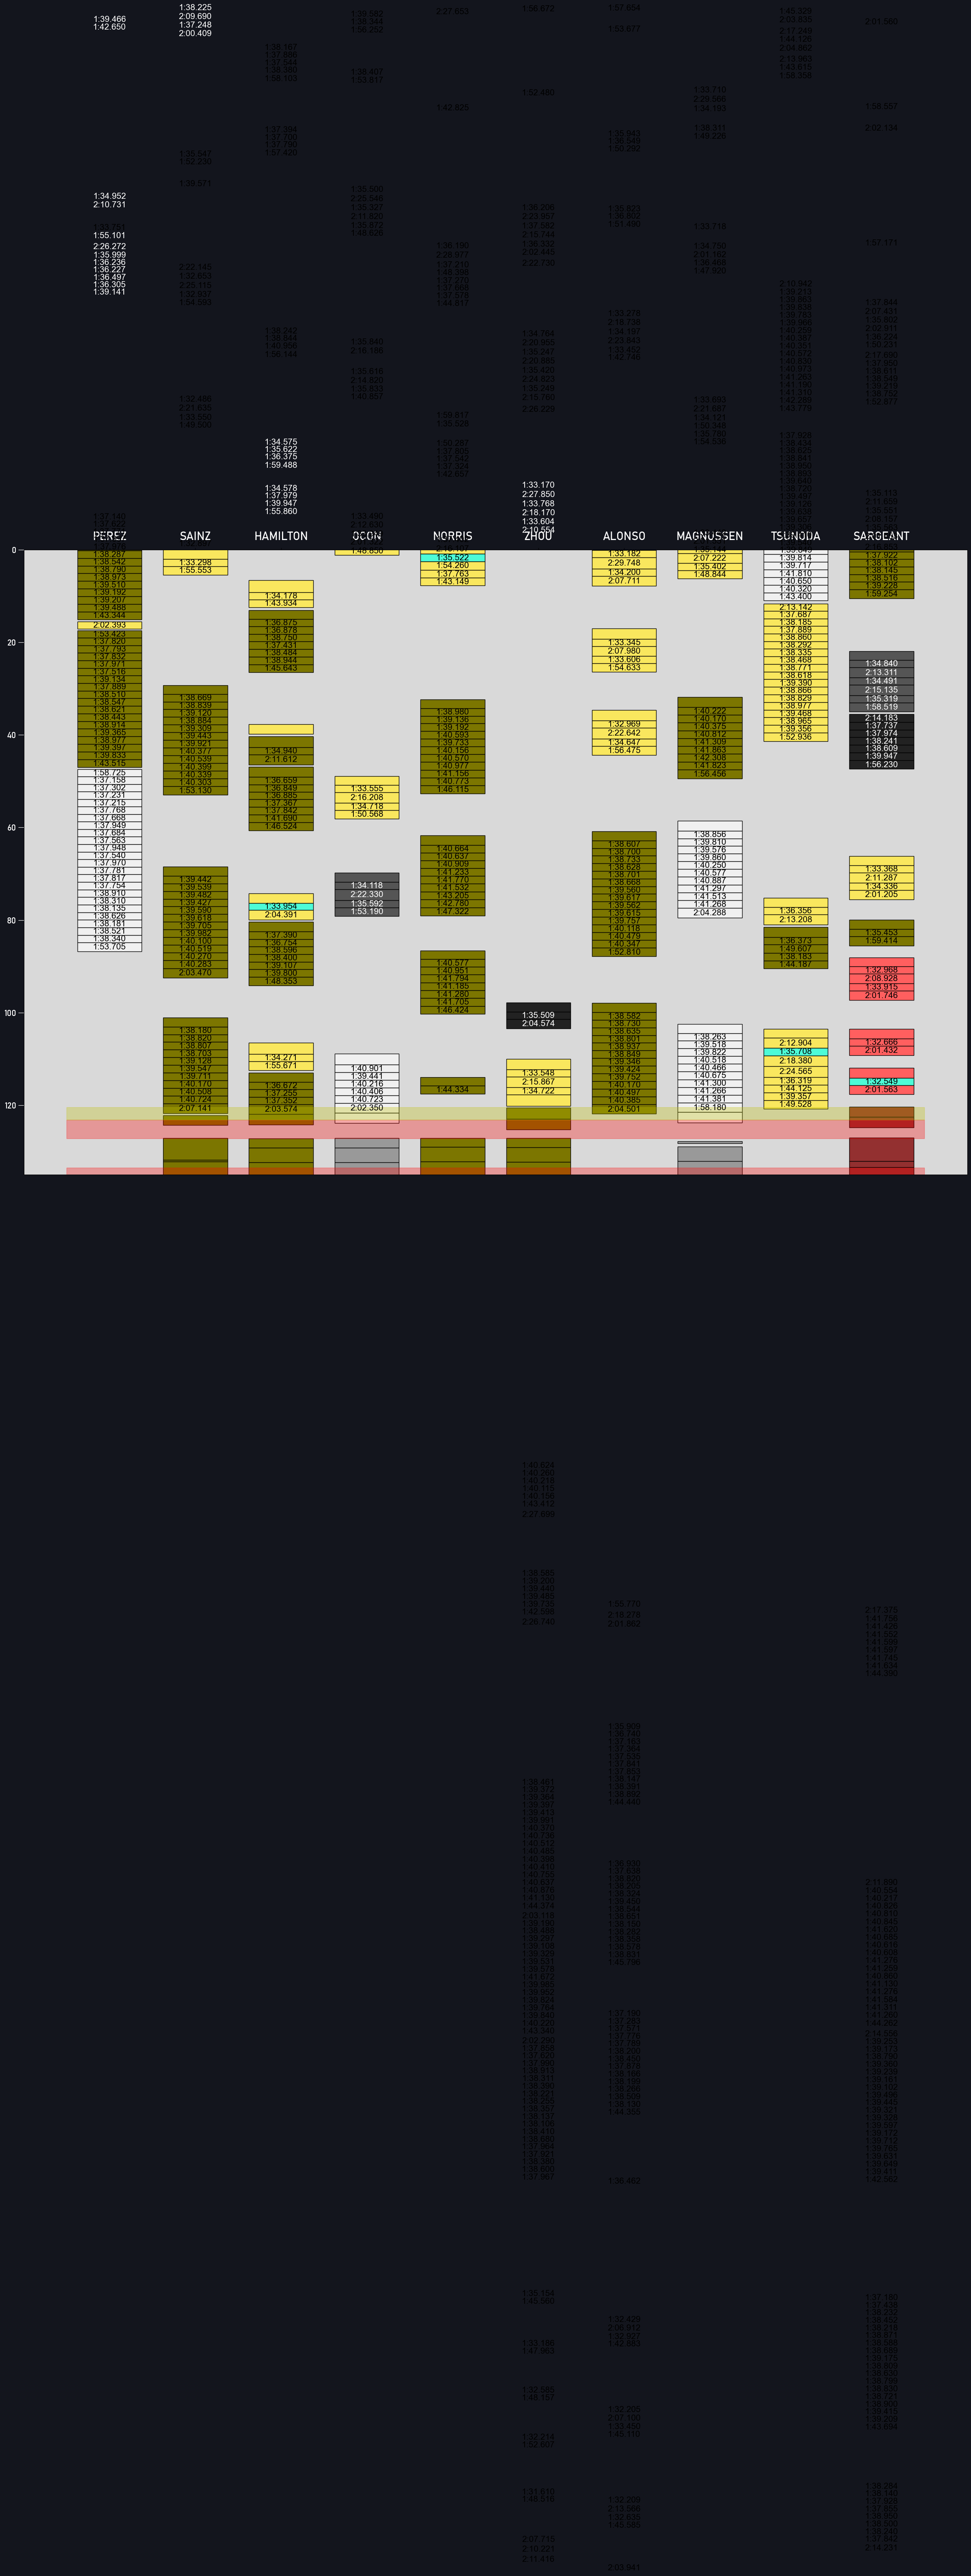

In [26]:
#create_testing_graphic(['16','55','11','1','63','44','31','14','4','3'],(getLastChequeredFlag()+7,getFirstGreenFlagTime()))
create_testing_graphic(['11','55','44','31','4','24','14','20','22','2'],(getFirstGreenFlagTime()+120+135,getFirstGreenFlagTime()+120))
#create_testing_graphic(topdrivers,(180,getFirstGreenFlagTime()))
#create_testing_graphic(botdrivers,(180,getFirstGreenFlagTime()))

In [23]:
#raceControl["Message"].to_list()
raceControl


,Time,Category,Message,Status,Flag,Scope,Sector,RacingNumber
0,2023-02-24 06:45:11,Other,RISK OF RAIN FOR THIS SESSION IS 0%,None,None,None,NaN,None
1,2023-02-24 06:57:05,Drs,DRS ENABLED,ENABLED,None,None,NaN,None
2,2023-02-24 07:00:00,Flag,GREEN LIGHT - PIT EXIT OPEN,None,GREEN,Track,NaN,None
3,2023-02-24 11:00:03,Flag,DOUBLE YELLOW IN TRACK SECTOR 6,None,DOUBLE YELLOW,Sector,6.0,None
4,2023-02-24 11:00:06,Flag,YELLOW IN TRACK SECTOR 5,None,YELLOW,Sector,5.0,None
5,2023-02-24 11:00:28,SafetyCar,VIRTUAL SAFETY CAR DEPLOYED,DEPLOYED,None,None,NaN,None
6,2023-02-24 11:03:10,Flag,RED FLAG,None,RED,Track,NaN,None
7,2023-02-24 11:05:16,Flag,TRACK CLEAR,None,CLEAR,Track,NaN,None
8,2023-02-24 11:07:13,Flag,GREEN LIGHT - PIT EXIT OPEN,None,GREEN,Track,NaN,None
9,2023-02-24 11:07:34,Other,STANDING START PROCEDURE,None,None,None,NaN,None


In [ ]:
from PIL import Image, ImageDraw
from PIL import ImageFont
font = ImageFont.truetype("bahnschrift.ttf",60)
background = Image.open(title+ " 1.png")
foreground = Image.open("dry.png")
draw = ImageDraw.Draw(background)
background.paste(foreground, (0, 0), foreground)
draw.text((1284-font.getlength(title.upper())/2,20),title.upper(),font=font)
background.save(title+" 1.png")

In [ ]:
usedCompounds = [*set(lapsDataFrame['Compound'].to_list())]

if 'TEST_UNKNOWN' in usedCompounds:
    mode = "testing"
elif ('INTERMEDIATE' in usedCompounds or 'WET' in usedCompounds) and ('HARD' in usedCompounds or 'MEDIUM' in usedCompounds or 'SOFT' in usedCompounds):
    mode = "wetanddry"
elif 'INTERMEDIATE' in usedCompounds or 'WET' in usedCompounds:
    mode = "wet"
elif 'HARD' in usedCompounds or 'MEDIUM' in usedCompounds or 'SOFT' in usedCompounds:
    mode = "dry"
print(mode)

dry


In [ ]:
rcm.to_csv('testing1.csv')

In [8]:
usedCompounds = [*set(lapsDataFrame['Compound'].to_list())]

In [9]:
usedCompounds

['TEST_UNKNOWN', 'SOFT', 'MEDIUM', 'HARD', 'UNKNOWN']